Лабораторная работа 3: Исследование Решающего дерева (Decision Tree)

Загрузка и подготовка данных
*масштабирование (StandardScaler) для деревьев НЕ требуется - это хороший плюс, потому что скейлинг частично мешал в процессе тюнинга моделей  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             mean_absolute_error, mean_squared_error, r2_score)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore')

df_class = pd.read_csv('../data/classification-train.csv')
df_reg = pd.read_csv('../data/boston-regression.csv')

# Классификация
X_cls = df_class.drop('price_range', axis=1)
y_cls = df_class['price_range']

# Регрессия
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Данные готовы")

Данные готовы


## Бейзлайн
Обучим деревья с параметрами по умолчанию. По умолчанию sklearn строит дерево до тех пор, пока в каждом листе не останется по 1 объекту. Это часто ведет к Overfitting.

In [10]:
# --- Классификация ---
dt_cls_base = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0)
dt_cls_base.fit(X_train_c, y_train_c)
y_pred_c_base = dt_cls_base.predict(X_test_c)

# --- Регрессия ---
dt_reg_base = DecisionTreeRegressor(random_state=42, ccp_alpha=0.0)
dt_reg_base.fit(X_train_r, y_train_r)
y_pred_r_base = dt_reg_base.predict(X_test_r)

def print_metrics(y_true, y_pred, task='classification', model_name='Model'):
    print(f"--- {model_name} ---")
    if task == 'classification':
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")
        return acc
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"RMSE: {rmse:.4f} | R2: {r2:.4f}")
        return r2

acc_base = print_metrics(y_test_c, y_pred_c_base, 'classification', 'Baseline Tree - classification')
r2_base = print_metrics(y_test_r, y_pred_r_base, 'regression', 'Baseline Tree - regression')

print("\n[Проверка переобучения]")
print(f"Train Accuracy: {dt_cls_base.score(X_train_c, y_train_c):.4f}")
print(f"Train R2: {dt_reg_base.score(X_train_r, y_train_r):.4f}")

--- Baseline Tree - classification ---
Accuracy: 0.8325 | F1: 0.8316
--- Baseline Tree - regression ---
RMSE: 3.2274 | R2: 0.8580

[Проверка переобучения]
Train Accuracy: 1.0000
Train R2: 1.0000


## Теперь затюним модель - нужно ограничить рост дерева\
max_depth: Ограничить глубину. Слишком глубокое дерево запоминает конкретные примеры\
min_samples_leaf: Запретить создавать листья, в которых слишком мало объектов\
criterion: Выбрать лучшую метрику ветвления\

Подбор гиперпараметров

In [43]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 5, 10, 20, 30],
}

# --- Классификация ---
param_grid_cls = param_grid.copy()
param_grid_cls['criterion'] = ['gini', 'entropy']

grid_cls = GridSearchCV(DecisionTreeClassifier(random_state=52, ccp_alpha=0.0), param_grid_cls, cv=10, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_c, y_train_c)

# --- Регрессия ---
param_grid_reg = param_grid.copy()
param_grid_reg['criterion'] = ['squared_error', 'absolute_error', 'friedman_mse']

grid_reg = GridSearchCV(DecisionTreeRegressor(random_state=52, ccp_alpha=0.0), param_grid_reg, cv=10, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_r, y_train_r)

print(f"Best Params (Class): {grid_cls.best_params_}")
print(f"Best Params (Reg): {grid_reg.best_params_}")

Best Params (Class): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Params (Reg): {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 30}


Применим лучшие параметры
видим незначительные улучшения во всех показателях

In [44]:
best_tree_cls = grid_cls.best_estimator_
best_tree_reg = grid_reg.best_estimator_

y_pred_c_tuned = best_tree_cls.predict(X_test_c)
y_pred_r_tuned = best_tree_reg.predict(X_test_r)

print_metrics(y_test_c, y_pred_c_tuned, 'classification', 'Tuned Tree - class')
print_metrics(y_test_r, y_pred_r_tuned, 'regression', 'Tuned Tree - reg')

--- Tuned Tree - class ---
Accuracy: 0.8325 | F1: 0.8341
--- Tuned Tree - reg ---
RMSE: 2.9887 | R2: 0.8782


0.8781935592133939

## Визуализация и интерпретация
Построим дерево\
Самый верхний узел - это самый важный признак. Это ram - совпадает с анализом из предыдущих лаб. Если ram поменьше - идем налево, больше - направо и т.д.

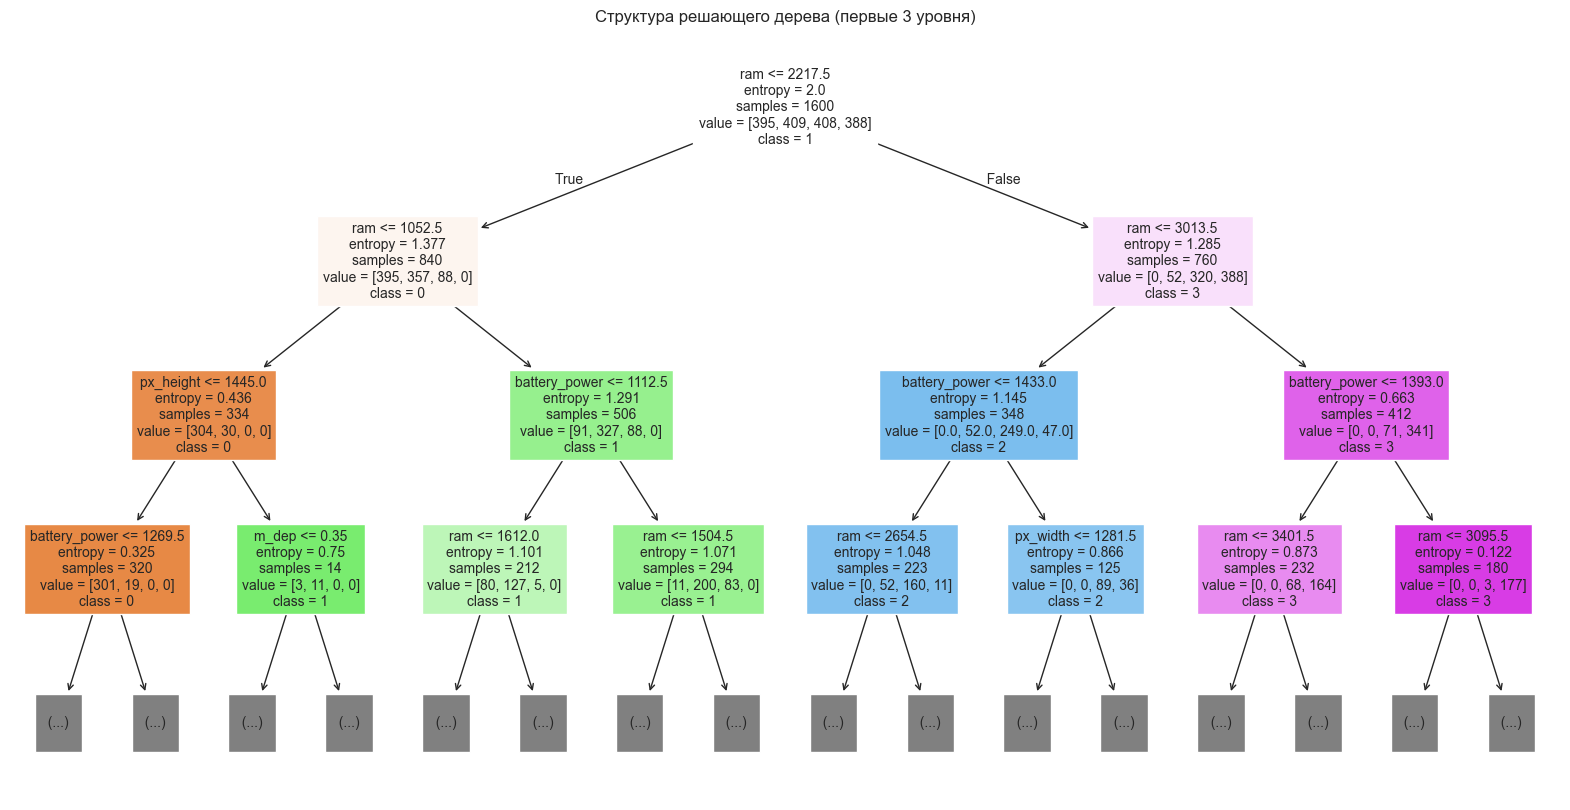

In [45]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree_cls, 
          max_depth=3, 
          feature_names=X_cls.columns, 
          class_names=[str(x) for x in sorted(y_cls.unique())], 
          filled=True, 
          fontsize=10)
plt.title('Структура решающего дерева (первые 3 уровня)')
plt.show()

Важность признаков\
Дерево считает важность как взвешенное уменьшение загрязнения\
В классификации признак ram доминирует над всеми остальными\
В регрессии же доминирует признак комнат и статуса населения

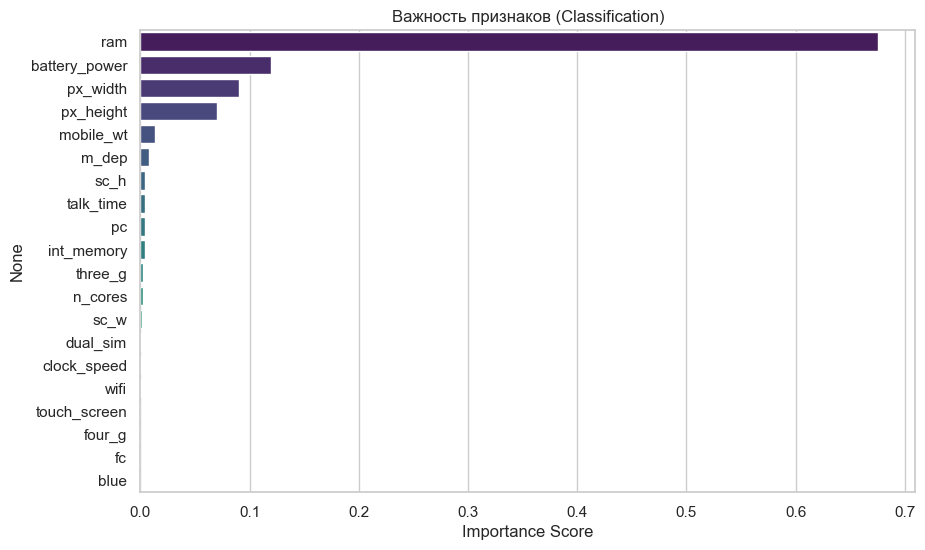

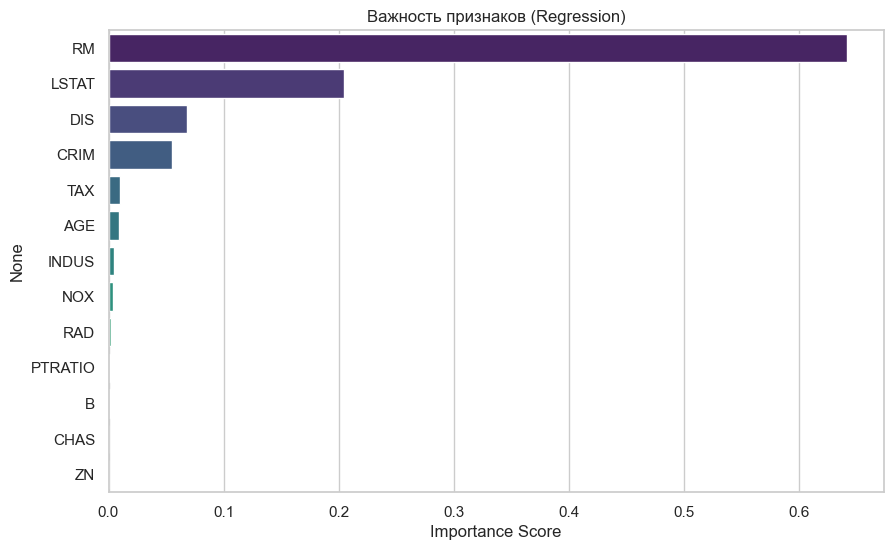

In [46]:
def plot_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.show()

plot_importance(best_tree_cls, X_cls.columns, 'Важность признаков (Classification)')
plot_importance(best_tree_reg, X_reg.columns, 'Важность признаков (Regression)')

Границы принятия решений
Построим график для двух самых важных признаков - оперативка и батарея, чтобы увидеть, как дерево нарезает пространство прямоугольниками\
Видим что границы строго ортогональны осям в отличие от косых линий линейной регрессии

<Figure size 1000x800 with 0 Axes>

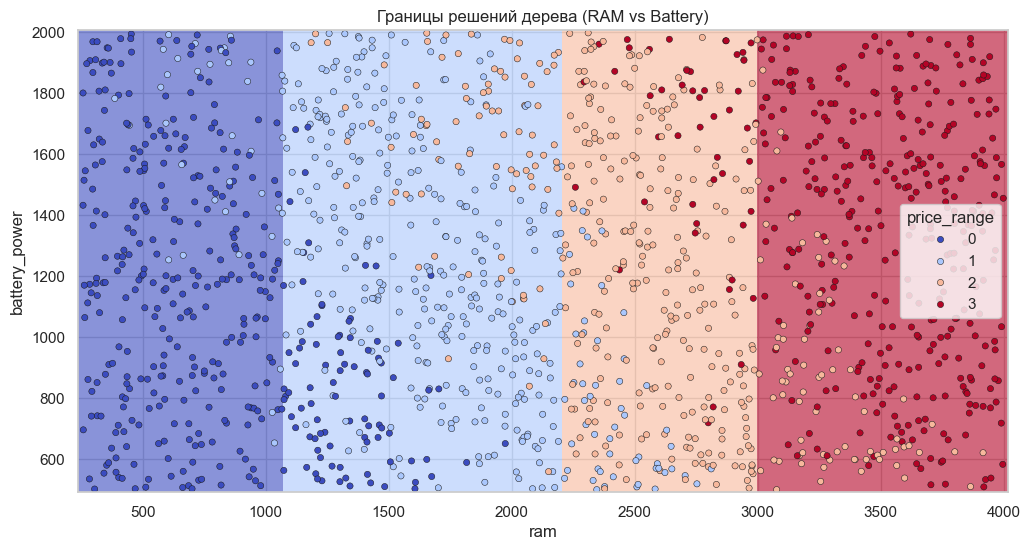

In [52]:
from sklearn.inspection import DecisionBoundaryDisplay

X_sub = X_train_c[['ram', 'battery_power']]
y_sub = y_train_c

tree_viz = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.025).fit(X_sub, y_sub)

plt.figure(figsize=(10, 8))
DecisionBoundaryDisplay.from_estimator(
    tree_viz, 
    X_sub, 
    response_method="predict",
    cmap="coolwarm", 
    plot_method="pcolormesh", 
    shading="auto",
    alpha=0.6
)
sns.scatterplot(x='ram', y='battery_power', hue=y_sub, data=X_sub, palette='coolwarm', edgecolor='k', s=20)
plt.title('Границы решений дерева (RAM vs Battery)')
plt.show()

## Самостоятельная имплементация
Рекурсивно делим данные, чтобы минимизировать "грязность" (Impurity) — Gini или MSE

In [53]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2, task='classification'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.root = None
        
    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y)) if self.task == 'classification' else None
        self.root = self._grow_tree(np.array(X), np.array(y))
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y) if self.task == 'classification' else np.mean(y)
            return Node(value=leaf_value)
        
        feat_idxs = np.random.choice(n_features, n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        
        if best_feat is None:
            leaf_value = self._most_common_label(y) if self.task == 'classification' else np.mean(y)
            return Node(value=leaf_value)
            
        left_idxs = X[:, best_feat] < best_thresh
        right_idxs = ~left_idxs
        
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth+1)
        
        return Node(best_feat, best_thresh, left, right)
    
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        
        parent_impurity = self._gini(y) if self.task == 'classification' else self._mse(y)
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            if len(thresholds) > 100:
                thresholds = np.percentile(X_column, np.linspace(0, 100, 10))
            
            for thr in thresholds:
                left_idxs = X_column < thr
                
                if np.sum(left_idxs) == 0 or np.sum(~left_idxs) == 0:
                    continue
                    
                y_left, y_right = y[left_idxs], y[~left_idxs]
                
                if self.task == 'classification':
                    imp_l, imp_r = self._gini(y_left), self._gini(y_right)
                else:
                    imp_l, imp_r = self._mse(y_left), self._mse(y_right)
                    
                n = len(y)
                n_l, n_r = len(y_left), len(y_right)
                child_impurity = (n_l/n) * imp_l + (n_r/n) * imp_r
                
                gain = parent_impurity - child_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thr
                    
        return split_idx, split_thresh
    
    def _gini(self, y):
        # 1 - sum(p^2)
        probas = [np.sum(y == c) / len(y) for c in np.unique(y)]
        return 1 - np.sum(np.array(probas)**2)
    
    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)
        
    def _most_common_label(self, y):
        return np.bincount(y).argmax()
        
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in np.array(X)])
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

Проверим CustomDecisionTree

In [54]:
# --- Classification Test ---
custom_tree_c = CustomDecisionTree(max_depth=10, min_samples_split=10, task='classification')
custom_tree_c.fit(X_train_c, y_train_c)
y_pred_c_custom = custom_tree_c.predict(X_test_c)

print("--- Custom Tree Classification ---")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_custom):.4f}")

# --- Regression Test ---
custom_tree_r = CustomDecisionTree(max_depth=5, min_samples_split=10, task='regression')
custom_tree_r.fit(X_train_r, y_train_r)
y_pred_r_custom = custom_tree_r.predict(X_test_r)

print("\n--- Custom Tree Regression ---")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r_custom):.4f}")

--- Custom Tree Classification ---
Accuracy: 0.8425

--- Custom Tree Regression ---
R2 Score: 0.7489


Сравним модели лаб1-3
KNN и Linear я возьму из предыдущих лаб
кнн - (acc = 0.94, r2 = 0.77)
linear - (acc = 0.88, r2= 0.85) 

,Model,Class Accuracy,Reg R2
0,KNN (Lab 1),0.9400,0.770000
1,Linear/Log Reg (Lab 2),0.8800,0.850000
2,Decision Tree (Lab 3),0.8325,0.878194


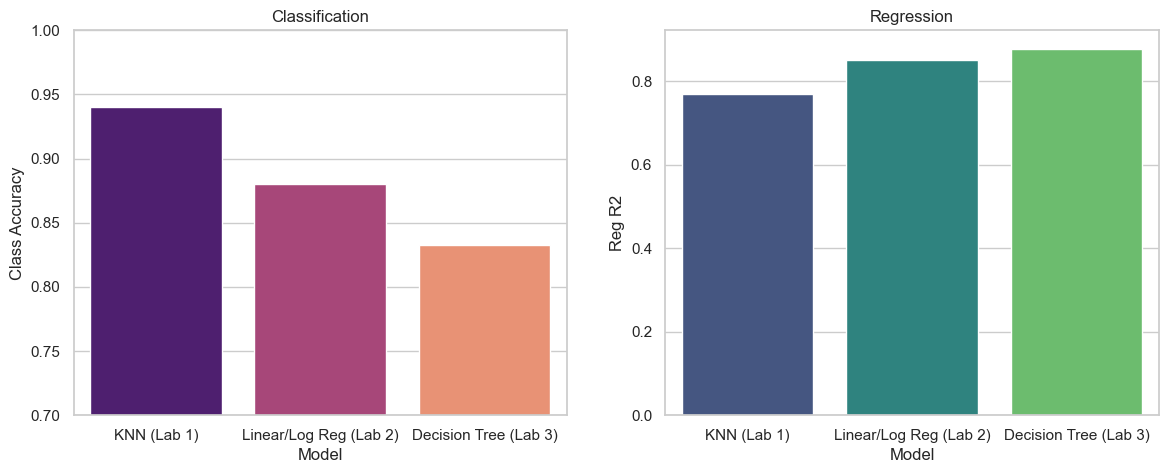

In [58]:
results = {
    'Model': ['KNN (Lab 1)', 'Linear/Log Reg (Lab 2)', 'Decision Tree (Lab 3)'],
    'Class Accuracy': [0.94, 0.88, accuracy_score(y_test_c, y_pred_c_tuned)],
    'Reg R2': [0.77, 0.85, r2_score(y_test_r, y_pred_r_tuned)]
}

df_res = pd.DataFrame(results)
display(df_res)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='Model', y='Class Accuracy', data=df_res, ax=ax[0], palette='magma')
ax[0].set_ylim(0.7, 1.0)
ax[0].set_title('Classification')

sns.barplot(x='Model', y='Reg R2', data=df_res, ax=ax[1], palette='viridis')
ax[1].set_title('Regression')

plt.show()

Выводы
1. Классификация (Mobile Price):\
  Дерево решений показало результат хуже, чем лог рег и кнн - это потому, что, как мы видели на графике границ, дерево строит прямоугольные области.\
  А зависимость цены от RAM диагональна. Дереву приходится аппроксимировать прямую линию лесенкой, что менее эффективно и требует глубокого дерева (которое начинает переобучаться)\
2. Регрессия (Boston Housing):\
  Дерево решений победило предыдущие модели. Данные в датасете имеют нелинейные зависимости (например LSTAT). Дерево легко находит пороги (например, если LSTAT > 20, цена падает резко), что хорошо описывает природу цен на жилье\
3. Плюсы и минусы дерева:\
  (+) Интерпретируемость: Мы точно знаем, какие пороги выбрала модель\
  (+) Нет препроцессинга: Не нужно было делать StandardScaler\
  (-) Нестабильность: Небольшое изменение в данных может полностью поменять структуру дерева\
  (-) Экстраполяция: Дерево не может предсказывать значения больше, чем видело в Train (в отличие от регрессии)\

Итог: Дерево решений — мощный инструмент для базового анализа и нелинейных задач, но как самостоятельный алгоритм - одно дерево - оно проигрывает ансамблям